# Векторные представления

Векторные представления как и многие другие вещи в датасаенсе раскрываются на огромных текстовых коллекция. Невозможно испортить векторную модель слишком большим количеством текста - она в любом случае будет только лучше. И наибольшую популярность эмбединги получили как раз тогда, когда придумали как обучаться на больших данных. Вектора, выложенные в общий доступ, в большинстве случаев обучены на корпусах из сотен миллинов токенов. 

Может показаться, что обучать свои представления, это безнадежное занятие - они все-равно не сравнятся с тем, что обучил гугл или фейсбук. Это не так. Хорошие эмбединги можно получить на совсем небольшом корпусе и иногда они могут даже оказаться лучше. Корпуса на которых обучают эбмеддинги - это чаще всего дампы википедии, новостные тексты и весь интернет подряд. Текстов по вашей специфичной теме там может не быть совсем или они утонут в куче однотипных новостей. 

Поэтому боятся обучать свои эмбединги не стоит. Тем более, что с генсимом и склерном это делается очень просто и быстро.

In [1]:
import pandas as pd
from lxml import html
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
import gensim
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter,defaultdict
from string import punctuation
import os
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
%matplotlib inline

morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return ' '.join(words)

def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]

    return ' '.join(words)


/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Давайте соберем небольшой корпус гуманитарных текстов (лингвистика, социология, история, философия) с сайта krugosvet.

In [30]:
# import requests
# from lxml import etree, html
# from time import sleep

In [80]:
# links = []

In [82]:
# # лингвистика
# for topic in [33, 37, 10, 13, 36, 12, 34, 39]:
#     for letter in 'абвгдезиклмнпростуфхцшщчуэюя':
#         for page_num in range(0, 30, 1):
#             r = requests.get(f'https://www.krugosvet.ru/taxonomy/term/{topic}/{letter}?page={page_num}')
#             if r.status_code != 200:
#                 continue
#             page = html.fromstring(r.text)
#             hrefs = page.xpath("//div[@class='article-teaser']/a/@href")
#             links += ['https://www.krugosvet.ru'+href for href in hrefs]
            
#     print('after topic - ', topic, ', links collected - ', len(links))

after topic -  33 , links collected -  586
after topic -  37 , links collected -  1523
after topic -  10 , links collected -  1683
after topic -  13 , links collected -  3444
after topic -  36 , links collected -  3803
after topic -  12 , links collected -  3875
after topic -  34 , links collected -  4103
after topic -  39 , links collected -  6083


In [90]:
# texts = []

# for link in tqdm(links):
#     r = requests.get(link)
#     if r.status_code != 200:
#         continue
#     page = html.fromstring(r.text)
#     text = "".join(page.xpath("//div[@id='article-content']/div[@class='body']//text()"))
#     texts.append(text)
    
    

100%|██████████| 6083/6083 [17:56<00:00,  5.65it/s]


In [115]:
# corpus_hum = open('corpus_hum.txt', 'w')

# for text in texts:
#     if len(text)>10:
#         corpus_hum.write(text + '\n')

# corpus_hum.close()

Откроем получившийся корпус.

In [2]:
data = open('corpus_hum.txt').read().splitlines()

data_norm = [normalize(text) for text in data]

In [3]:
data_norm = [text for text in data_norm if text]

In [234]:
data_norm[:5]

['абай василий васо иван 1900–2001 русский лингвист родиться 2 15 декабрь 1900 с.коби тифлисский губерния ныне грузия 1925 окончить факультет общественный наука ленинградский университет 1928 аспирантура 1928–1930 сотрудник кавказский историко-археологический институт ан ссср 1930 полвека работать яфетический институт затем институт язык мышление институт языкознание ан ссср ленинград 1950 москва доктор филологический наука 1962 профессор 1969 лауреат государственный премия ссср 1981 почётный член азиатский королевский общество великобритания ирландия 1966 член-корреспондент финно-угорский общество хельсинки 1973 умереть абай москва 18 март 2001',
 'также тема',
 'лингвистика языкознание языковедение',
 'ученик н.я.марра ранний работа находиться влияние идея который впоследствии отойти видный специалист история иранский язык свой родной осетинский язык автор фундаментальный историко-этимологический словарь осетинский язык 5-ти том 1958–1990 заниматься также мифология фольклор иранский 

In [4]:
len(data_norm)

115082

## Матричные разложения

Попробуем сначала матричные разложения. В SVD и в NMF одна из получаемых матриц имеет размерность (количество слов, количесто "тем"). Вектора из этих матриц и будут искомыми эбмедингами.

Для построение изнчальной матрицы слова на документы воспользуемся CountVectorizer из sklearn.

In [5]:
cv = CountVectorizer(min_df=3, max_df=0.4, max_features=1000)
X = cv.fit_transform(data_norm)

In [6]:
X.shape

(115082, 1000)

Разложим матрицу. Сначала попробуем только две размерности, чтобы визуализировать вектора.

In [7]:
svd = TruncatedSVD(2)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [306]:
# можно использовать побольше размерность, но тогда не получится визуализовать напрямую
# можно дополнительно пропустить через TSNE - метод специально для визуализации
# svd = TruncatedSVD(200)
# svd.fit(X)
# tsne = TSNE(2).fit_transform(svd.components_.T)

In [8]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

Попробуем визуализировать полученные вектора. Все слова визуализировать не получится, но можно попробовать взять какое-то количество случайных слов.

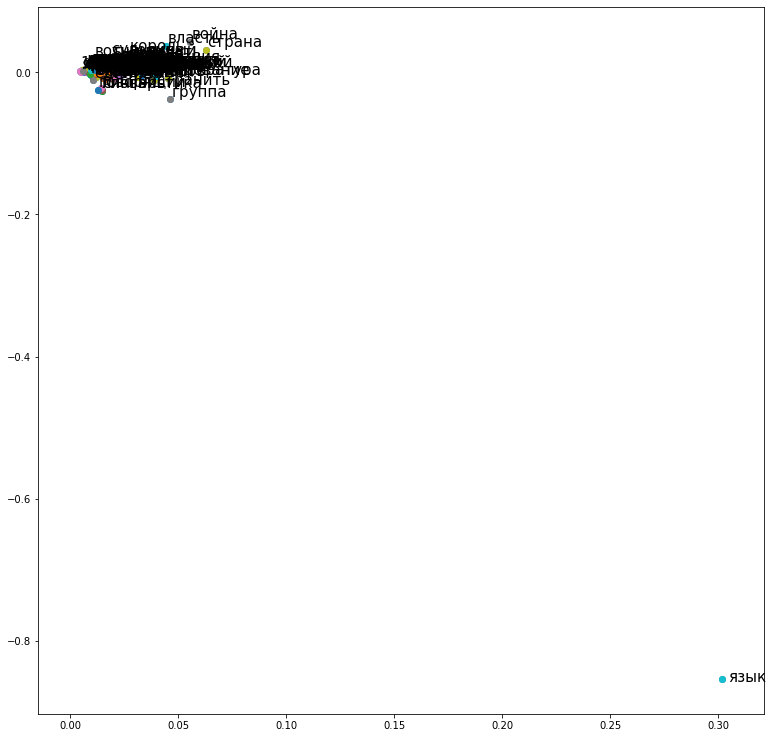

In [9]:
random_inds = np.random.choice(range(len(id2word)), 100, replace=False) 
res = svd.components_.T[random_inds] # закомментируйте эту ячейку для TSNE
# res = tsne[random_inds] # а эту наоборот раскомментируйте

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(random_inds):
    x, y = res[i, 0], res[i, 1]
    plt.scatter(x, y)
    
    plt.annotate(id2word[coor], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

Получается не очень красиво. Почти все слова сбиваются в кучу. 

Но визуализация ещё ничего не говорит. Посмотрим на близкие слова.

Перестроим разложения с большим количеством параметров.

In [10]:
nmf = NMF(50)
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [11]:
svd = TruncatedSVD(50)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0)

In [12]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

In [13]:
id2vec_svd = nmf.components_.T

In [14]:
id2vec_nmf = svd.components_.T

In [15]:
def most_similar(word, id2vec):
    similar = [id2word[i] for i in cosine_distances(id2vec[word2id[word]].reshape(1, -1), id2vec).argsort()[0][:10]]
    return similar

In [16]:
most_similar('владимир', id2vec_svd)
# попробуйте другие слова

['владимир',
 'иван',
 'князь',
 'земля',
 'царь',
 'московский',
 'великий',
 'монастырь',
 'великое',
 'небо']

In [17]:
most_similar("владимир", id2vec_nmf)

['владимир',
 'иван',
 'князь',
 'московский',
 'александр',
 'царь',
 'брат',
 'москва',
 'великий',
 'земля']

По похожим словам вектора выглядят достаточно хорошо.

Попробуем ещё кластеризовть полученные слова. Одна из метрик хороших векторов - их кластеризуемость (т.е. насколько хорошие получаются кластеры, можно ли сразу дать им какое-то название).

Сделаем кластеризацию с помощью MiniBatchKmeans.

In [332]:
cluster = MiniBatchKMeans(30, n_init=2, verbose=1, max_no_improvement=100, reassignment_ratio=0.4)
cluster.fit(nmf.components_.T)

Init 1/2 with method: k-means++
Inertia for init 1/2: 2035.590601
Init 2/2 with method: k-means++
Inertia for init 2/2: 1752.455816
Minibatch iteration 1/1000: mean batch inertia: 4.095008, ewa inertia: 4.095008 
Minibatch iteration 2/1000: mean batch inertia: 1.633703, ewa inertia: 3.603239 
Minibatch iteration 3/1000: mean batch inertia: 16.912522, ewa inertia: 6.262436 
Minibatch iteration 4/1000: mean batch inertia: 6.003663, ewa inertia: 6.210733 
Minibatch iteration 5/1000: mean batch inertia: 10.038974, ewa inertia: 6.975617 
Minibatch iteration 6/1000: mean batch inertia: 3.956025, ewa inertia: 6.372302 
Minibatch iteration 7/1000: mean batch inertia: 20.797345, ewa inertia: 9.254428 
Minibatch iteration 8/1000: mean batch inertia: 28.352053, ewa inertia: 13.070137 
Minibatch iteration 9/1000: mean batch inertia: 12.302539, ewa inertia: 12.916771 
[MiniBatchKMeans] Reassigning 28 cluster centers.
Minibatch iteration 10/1000: mean batch inertia: 7.918765, ewa inertia: 11.918168 

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=100,
        n_clusters=30, n_init=2, random_state=None, reassignment_ratio=0.4,
        tol=0.0, verbose=1)

Сохраним кластеры в текстовый файл и просто полистаем.

In [333]:

cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(id2word[i])
# откройте в любом текстовом редакторе
f = open('cluster_nmf.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

## Word2Vec и Fasttext

Проделаем тоже самое для ворд2века и фастекста. 

Интерфейс в gensim практически такой же как и в LDA. Только строить словарь не нужно.

In [18]:
fast_text = gensim.models.FastText([text.split() for text in data_norm], size=50, 
                                   min_n=4, max_n=8) 
w2v = gensim.models.Word2Vec([text.split() for text in data_norm], size=50, sg=1)


/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


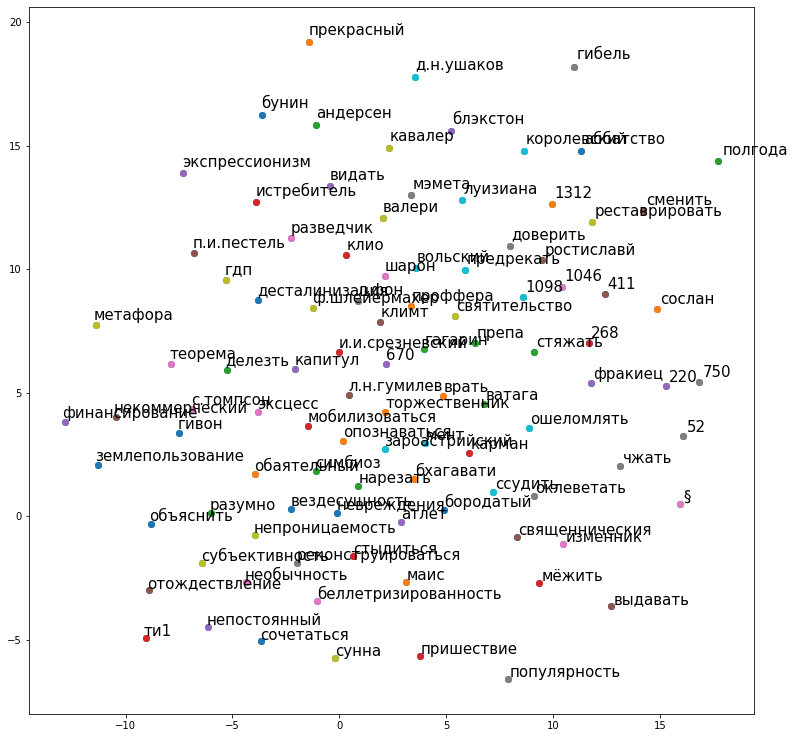

In [19]:
random_words = np.random.choice(w2v.wv.index2word, 100, replace=False)
res = w2v[random_words]
res = TSNE(2).fit_transform(res)

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(res):
    x, y = coor
    plt.scatter(x, y)
    
    plt.annotate(random_words[i], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

Опять же ничего хорошего на график не рисуется.

Посмотрим на близкие слова.

In [27]:
fast_text.most_similar('язык')
# чтобы отчетливо увидеть различия фастекста и ворд2века
# подставьте какое-то несуществующее слово (например, с опечаткой или с говорящей частью - "хренология" хороший пример)
# или попробуйте ввести слово с характерной составляющей (суффиксом прошедшего времени, приставкой пере)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('н.м.язык', 0.9949963092803955),
 ('праязык', 0.9454808235168457),
 ('подъязык', 0.9194867610931396),
 ('язык-предок', 0.8936646580696106),
 ('языкова', 0.8671830296516418),
 ('язык-цель', 0.850830614566803),
 ('метаязык', 0.8380059003829956),
 ('протоязык', 0.8032997846603394),
 ('языковед', 0.779621958732605),
 ('диалект', 0.7663685083389282)]

In [28]:
w2v.most_similar('язык')

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('древнееврейский', 0.8318796157836914),
 ('иврит', 0.7822853326797485),
 ('латынь', 0.7792429327964783),
 ('идиш', 0.7611494660377502),
 ('подлинник', 0.7582873702049255),
 ('церковно-славянский', 0.7511679530143738),
 ('старофранцузский', 0.749047040939331),
 ('фарси', 0.748748779296875),
 ('перевод', 0.7477747201919556),
 ('двуязычный', 0.7475094795227051)]

Ну и на кластеры давайте тоже посмотрим.

In [29]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text[word]

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [258]:
cluster = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

Init 1/2 with method: k-means++


/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/2: 456.830752
Init 2/2 with method: k-means++
Inertia for init 2/2: 539.965201
Minibatch iteration 1/44200: mean batch inertia: 11.523366, ewa inertia: 11.523366 
Minibatch iteration 2/44200: mean batch inertia: 11.919308, ewa inertia: 11.525158 
Minibatch iteration 3/44200: mean batch inertia: 11.402294, ewa inertia: 11.524602 
Minibatch iteration 4/44200: mean batch inertia: 10.656444, ewa inertia: 11.520673 
Minibatch iteration 5/44200: mean batch inertia: 9.941317, ewa inertia: 11.513526 
Minibatch iteration 6/44200: mean batch inertia: 8.147925, ewa inertia: 11.498294 
Minibatch iteration 7/44200: mean batch inertia: 17.888492, ewa inertia: 11.527214 
Minibatch iteration 8/44200: mean batch inertia: 11.481881, ewa inertia: 11.527009 
Minibatch iteration 9/44200: mean batch inertia: 13.576250, ewa inertia: 11.536283 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/44200: mean batch inertia: 8.288334, ewa inertia: 11.521584 
Minibatch iter

Minibatch iteration 105/44200: mean batch inertia: 9.758970, ewa inertia: 11.059807 
Minibatch iteration 106/44200: mean batch inertia: 9.461751, ewa inertia: 11.052575 
Minibatch iteration 107/44200: mean batch inertia: 7.558701, ewa inertia: 11.036763 
Minibatch iteration 108/44200: mean batch inertia: 8.639091, ewa inertia: 11.025912 
Minibatch iteration 109/44200: mean batch inertia: 11.750024, ewa inertia: 11.029189 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 110/44200: mean batch inertia: 11.385322, ewa inertia: 11.030801 
Minibatch iteration 111/44200: mean batch inertia: 26.928494, ewa inertia: 11.102748 
Minibatch iteration 112/44200: mean batch inertia: 7.678750, ewa inertia: 11.087252 
Minibatch iteration 113/44200: mean batch inertia: 7.349966, ewa inertia: 11.070339 
Minibatch iteration 114/44200: mean batch inertia: 7.539572, ewa inertia: 11.054360 
Minibatch iteration 115/44200: mean batch inertia: 8.873892, ewa inertia: 11.044492 
Minibatch it

Minibatch iteration 206/44200: mean batch inertia: 9.419940, ewa inertia: 10.293790 
Minibatch iteration 207/44200: mean batch inertia: 14.112879, ewa inertia: 10.311074 
Minibatch iteration 208/44200: mean batch inertia: 8.849556, ewa inertia: 10.304460 
Minibatch iteration 209/44200: mean batch inertia: 10.619379, ewa inertia: 10.305885 
Minibatch iteration 210/44200: mean batch inertia: 7.635159, ewa inertia: 10.293798 
Minibatch iteration 211/44200: mean batch inertia: 7.426267, ewa inertia: 10.280821 
Minibatch iteration 212/44200: mean batch inertia: 7.689917, ewa inertia: 10.269095 
Minibatch iteration 213/44200: mean batch inertia: 9.607239, ewa inertia: 10.266100 
Minibatch iteration 214/44200: mean batch inertia: 9.965833, ewa inertia: 10.264741 
Minibatch iteration 215/44200: mean batch inertia: 11.970470, ewa inertia: 10.272461 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 216/44200: mean batch inertia: 10.146086, ewa inertia: 10.271889 
Minibatch i

Minibatch iteration 306/44200: mean batch inertia: 7.732118, ewa inertia: 9.894709 
Minibatch iteration 307/44200: mean batch inertia: 8.340965, ewa inertia: 9.887677 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 308/44200: mean batch inertia: 10.071758, ewa inertia: 9.888510 
Minibatch iteration 309/44200: mean batch inertia: 8.316136, ewa inertia: 9.881394 
Minibatch iteration 310/44200: mean batch inertia: 7.966726, ewa inertia: 9.872729 
Minibatch iteration 311/44200: mean batch inertia: 8.656643, ewa inertia: 9.867226 
Minibatch iteration 312/44200: mean batch inertia: 19.429623, ewa inertia: 9.910501 
Minibatch iteration 313/44200: mean batch inertia: 6.968810, ewa inertia: 9.897188 
Minibatch iteration 314/44200: mean batch inertia: 10.771968, ewa inertia: 9.901147 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 315/44200: mean batch inertia: 11.520101, ewa inertia: 9.908474 
Minibatch iteration 316/44200: mean batch inertia: 6.698

Minibatch iteration 403/44200: mean batch inertia: 6.601271, ewa inertia: 9.833403 
Minibatch iteration 404/44200: mean batch inertia: 7.732607, ewa inertia: 9.823895 
Minibatch iteration 405/44200: mean batch inertia: 12.651284, ewa inertia: 9.836691 
Minibatch iteration 406/44200: mean batch inertia: 6.540327, ewa inertia: 9.821773 
Minibatch iteration 407/44200: mean batch inertia: 10.929735, ewa inertia: 9.826787 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 408/44200: mean batch inertia: 16.752307, ewa inertia: 9.858129 
Minibatch iteration 409/44200: mean batch inertia: 6.793712, ewa inertia: 9.844261 
Minibatch iteration 410/44200: mean batch inertia: 18.563328, ewa inertia: 9.883720 
Minibatch iteration 411/44200: mean batch inertia: 12.817428, ewa inertia: 9.896997 
Minibatch iteration 412/44200: mean batch inertia: 6.070129, ewa inertia: 9.879678 
Minibatch iteration 413/44200: mean batch inertia: 9.806738, ewa inertia: 9.879348 
Minibatch iteration 4

Minibatch iteration 500/44200: mean batch inertia: 11.715427, ewa inertia: 9.782622 
Minibatch iteration 501/44200: mean batch inertia: 8.259848, ewa inertia: 9.775731 
Minibatch iteration 502/44200: mean batch inertia: 11.280076, ewa inertia: 9.782539 
Minibatch iteration 503/44200: mean batch inertia: 8.380523, ewa inertia: 9.776194 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 504/44200: mean batch inertia: 11.787377, ewa inertia: 9.785296 
Minibatch iteration 505/44200: mean batch inertia: 10.738330, ewa inertia: 9.789609 
Minibatch iteration 506/44200: mean batch inertia: 7.582855, ewa inertia: 9.779622 
Minibatch iteration 507/44200: mean batch inertia: 11.784011, ewa inertia: 9.788693 
Minibatch iteration 508/44200: mean batch inertia: 8.803838, ewa inertia: 9.784236 
Minibatch iteration 509/44200: mean batch inertia: 14.156005, ewa inertia: 9.804021 
Minibatch iteration 510/44200: mean batch inertia: 12.418111, ewa inertia: 9.815851 
Minibatch iteration

[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 598/44200: mean batch inertia: 13.566587, ewa inertia: 9.645276 
Minibatch iteration 599/44200: mean batch inertia: 14.190530, ewa inertia: 9.665846 
Minibatch iteration 600/44200: mean batch inertia: 6.683602, ewa inertia: 9.652350 
Minibatch iteration 601/44200: mean batch inertia: 6.146568, ewa inertia: 9.636484 
Minibatch iteration 602/44200: mean batch inertia: 10.819223, ewa inertia: 9.641837 
Minibatch iteration 603/44200: mean batch inertia: 9.598740, ewa inertia: 9.641642 
Minibatch iteration 604/44200: mean batch inertia: 10.058912, ewa inertia: 9.643530 
Minibatch iteration 605/44200: mean batch inertia: 10.300422, ewa inertia: 9.646503 
Minibatch iteration 606/44200: mean batch inertia: 7.091852, ewa inertia: 9.634941 
Minibatch iteration 607/44200: mean batch inertia: 9.405751, ewa inertia: 9.633904 
Minibatch iteration 608/44200: mean batch inertia: 7.760786, ewa inertia: 9.625427 
Minibatch iteration 6

Minibatch iteration 693/44200: mean batch inertia: 6.803142, ewa inertia: 9.347942 
Minibatch iteration 694/44200: mean batch inertia: 10.354452, ewa inertia: 9.352497 
Minibatch iteration 695/44200: mean batch inertia: 8.653870, ewa inertia: 9.349335 
Minibatch iteration 696/44200: mean batch inertia: 7.434471, ewa inertia: 9.340669 
Minibatch iteration 697/44200: mean batch inertia: 7.940422, ewa inertia: 9.334332 
Minibatch iteration 698/44200: mean batch inertia: 8.757895, ewa inertia: 9.331724 
Minibatch iteration 699/44200: mean batch inertia: 7.255070, ewa inertia: 9.322326 
Minibatch iteration 700/44200: mean batch inertia: 13.836521, ewa inertia: 9.342755 
Minibatch iteration 701/44200: mean batch inertia: 8.400021, ewa inertia: 9.338489 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 702/44200: mean batch inertia: 8.373478, ewa inertia: 9.334121 
Minibatch iteration 703/44200: mean batch inertia: 8.056142, ewa inertia: 9.328338 
Minibatch iteration 704/

Minibatch iteration 793/44200: mean batch inertia: 7.678943, ewa inertia: 9.353514 
Minibatch iteration 794/44200: mean batch inertia: 10.200097, ewa inertia: 9.357345 
Minibatch iteration 795/44200: mean batch inertia: 8.762083, ewa inertia: 9.354651 
Minibatch iteration 796/44200: mean batch inertia: 7.751862, ewa inertia: 9.347398 
Minibatch iteration 797/44200: mean batch inertia: 8.430117, ewa inertia: 9.343246 
Minibatch iteration 798/44200: mean batch inertia: 8.184549, ewa inertia: 9.338003 
Minibatch iteration 799/44200: mean batch inertia: 9.048961, ewa inertia: 9.336695 
Minibatch iteration 800/44200: mean batch inertia: 6.913906, ewa inertia: 9.325730 
Minibatch iteration 801/44200: mean batch inertia: 8.184636, ewa inertia: 9.320566 
Minibatch iteration 802/44200: mean batch inertia: 8.714647, ewa inertia: 9.317824 
Minibatch iteration 803/44200: mean batch inertia: 12.894231, ewa inertia: 9.334009 
Minibatch iteration 804/44200: mean batch inertia: 7.127956, ewa inertia: 

Minibatch iteration 894/44200: mean batch inertia: 8.563002, ewa inertia: 9.336812 
Minibatch iteration 895/44200: mean batch inertia: 6.837930, ewa inertia: 9.325503 
Minibatch iteration 896/44200: mean batch inertia: 8.175018, ewa inertia: 9.320296 
Minibatch iteration 897/44200: mean batch inertia: 14.527065, ewa inertia: 9.343860 
Minibatch iteration 898/44200: mean batch inertia: 20.950741, ewa inertia: 9.396388 
Minibatch iteration 899/44200: mean batch inertia: 5.799173, ewa inertia: 9.380109 
Minibatch iteration 900/44200: mean batch inertia: 8.170562, ewa inertia: 9.374635 
Minibatch iteration 901/44200: mean batch inertia: 7.030804, ewa inertia: 9.364027 
Minibatch iteration 902/44200: mean batch inertia: 5.487685, ewa inertia: 9.346485 
Minibatch iteration 903/44200: mean batch inertia: 11.498298, ewa inertia: 9.356223 
Minibatch iteration 904/44200: mean batch inertia: 7.832587, ewa inertia: 9.349328 
Minibatch iteration 905/44200: mean batch inertia: 17.058532, ewa inertia

Minibatch iteration 996/44200: mean batch inertia: 9.690577, ewa inertia: 9.289904 
Minibatch iteration 997/44200: mean batch inertia: 9.906704, ewa inertia: 9.292695 
Minibatch iteration 998/44200: mean batch inertia: 6.201208, ewa inertia: 9.278704 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 999/44200: mean batch inertia: 6.299971, ewa inertia: 9.265224 
Minibatch iteration 1000/44200: mean batch inertia: 8.211848, ewa inertia: 9.260456 
Minibatch iteration 1001/44200: mean batch inertia: 12.269152, ewa inertia: 9.274073 
Minibatch iteration 1002/44200: mean batch inertia: 7.581383, ewa inertia: 9.266412 
Minibatch iteration 1003/44200: mean batch inertia: 8.572566, ewa inertia: 9.263272 
Minibatch iteration 1004/44200: mean batch inertia: 9.644700, ewa inertia: 9.264998 
Minibatch iteration 1005/44200: mean batch inertia: 7.883466, ewa inertia: 9.258746 
Minibatch iteration 1006/44200: mean batch inertia: 7.028793, ewa inertia: 9.248654 
Minibatch iteratio

Преимущество фастекста в том, что он учитывает символьные нграммы (что примерно равно учету морфологии). Попробуем подать ему на вход ненормализованные тексты.

In [270]:
corpus = [tokenize(text).split() for text in data]
corpus = list(filter(bool, corpus))
fast_text = gensim.models.FastText(corpus, size=50)

In [272]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text[word]
        
cluster = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Init 1/2 with method: k-means++
Inertia for init 1/2: 2224.922991
Init 2/2 with method: k-means++
Inertia for init 2/2: 1961.877620
Minibatch iteration 1/88000: mean batch inertia: 36.003736, ewa inertia: 36.003736 
Minibatch iteration 2/88000: mean batch inertia: 33.177047, ewa inertia: 35.997311 
Minibatch iteration 3/88000: mean batch inertia: 36.192729, ewa inertia: 35.997755 
Minibatch iteration 4/88000: mean batch inertia: 36.391619, ewa inertia: 35.998650 
Minibatch iteration 5/88000: mean batch inertia: 72.812178, ewa inertia: 36.082324 
Minibatch iteration 6/88000: mean batch inertia: 32.066722, ewa inertia: 36.073197 
Minibatch iteration 7/88000: mean batch inertia: 27.867531, ewa inertia: 36.054546 
Minibatch iteration 8/88000: mean batch inertia: 34.589264, ewa inertia: 36.051216 
Minibatch iteration 9/88000: mean batch inertia: 26.569088, ewa inertia: 36.029664 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/88000: mean batch inertia: 31.134591, e

Minibatch iteration 105/88000: mean batch inertia: 30.209353, ewa inertia: 35.102417 
Minibatch iteration 106/88000: mean batch inertia: 34.342239, ewa inertia: 35.100689 
Minibatch iteration 107/88000: mean batch inertia: 29.112044, ewa inertia: 35.087078 
Minibatch iteration 108/88000: mean batch inertia: 27.518962, ewa inertia: 35.069876 
Minibatch iteration 109/88000: mean batch inertia: 32.719558, ewa inertia: 35.064534 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 110/88000: mean batch inertia: 23.304316, ewa inertia: 35.037804 
Minibatch iteration 111/88000: mean batch inertia: 26.130041, ewa inertia: 35.017557 
Minibatch iteration 112/88000: mean batch inertia: 25.703828, ewa inertia: 34.996388 
Minibatch iteration 113/88000: mean batch inertia: 27.161766, ewa inertia: 34.978581 
Minibatch iteration 114/88000: mean batch inertia: 32.019897, ewa inertia: 34.971856 
Minibatch iteration 115/88000: mean batch inertia: 30.712931, ewa inertia: 34.962176 
Mini

Minibatch iteration 207/88000: mean batch inertia: 27.718743, ewa inertia: 33.376306 
Minibatch iteration 208/88000: mean batch inertia: 25.520193, ewa inertia: 33.358449 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 209/88000: mean batch inertia: 28.149927, ewa inertia: 33.346611 
Minibatch iteration 210/88000: mean batch inertia: 31.144469, ewa inertia: 33.341606 
Minibatch iteration 211/88000: mean batch inertia: 23.333445, ewa inertia: 33.318858 
Minibatch iteration 212/88000: mean batch inertia: 21.981291, ewa inertia: 33.293089 
Minibatch iteration 213/88000: mean batch inertia: 24.043920, ewa inertia: 33.272066 
Minibatch iteration 214/88000: mean batch inertia: 26.576409, ewa inertia: 33.256848 
Minibatch iteration 215/88000: mean batch inertia: 24.717906, ewa inertia: 33.237439 
Minibatch iteration 216/88000: mean batch inertia: 22.856160, ewa inertia: 33.213844 
Minibatch iteration 217/88000: mean batch inertia: 25.034653, ewa inertia: 33.195253 
Mini

Minibatch iteration 301/88000: mean batch inertia: 29.124118, ewa inertia: 32.093362 
Minibatch iteration 302/88000: mean batch inertia: 23.573916, ewa inertia: 32.073998 
Minibatch iteration 303/88000: mean batch inertia: 25.972392, ewa inertia: 32.060130 
Minibatch iteration 304/88000: mean batch inertia: 32.353667, ewa inertia: 32.060797 
Minibatch iteration 305/88000: mean batch inertia: 26.542909, ewa inertia: 32.048255 
Minibatch iteration 306/88000: mean batch inertia: 27.815695, ewa inertia: 32.038635 
Minibatch iteration 307/88000: mean batch inertia: 27.945236, ewa inertia: 32.029331 
Minibatch iteration 308/88000: mean batch inertia: 23.081111, ewa inertia: 32.008993 
Minibatch iteration 309/88000: mean batch inertia: 25.334149, ewa inertia: 31.993821 
Minibatch iteration 310/88000: mean batch inertia: 23.417090, ewa inertia: 31.974327 
Minibatch iteration 311/88000: mean batch inertia: 25.752905, ewa inertia: 31.960186 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Mini

Minibatch iteration 405/88000: mean batch inertia: 24.803668, ewa inertia: 31.060283 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 406/88000: mean batch inertia: 22.269740, ewa inertia: 31.040303 
Minibatch iteration 407/88000: mean batch inertia: 27.524606, ewa inertia: 31.032312 
Minibatch iteration 408/88000: mean batch inertia: 168.831516, ewa inertia: 31.345517 
Minibatch iteration 409/88000: mean batch inertia: 22.443162, ewa inertia: 31.325283 
Minibatch iteration 410/88000: mean batch inertia: 24.782429, ewa inertia: 31.310411 
Minibatch iteration 411/88000: mean batch inertia: 24.621894, ewa inertia: 31.295209 
Minibatch iteration 412/88000: mean batch inertia: 26.572689, ewa inertia: 31.284475 
Minibatch iteration 413/88000: mean batch inertia: 28.311170, ewa inertia: 31.277717 
Minibatch iteration 414/88000: mean batch inertia: 24.642706, ewa inertia: 31.262636 
Minibatch iteration 415/88000: mean batch inertia: 21.863758, ewa inertia: 31.241274 
Min

Minibatch iteration 509/88000: mean batch inertia: 25.548362, ewa inertia: 30.607064 
Minibatch iteration 510/88000: mean batch inertia: 23.601327, ewa inertia: 30.591140 
Minibatch iteration 511/88000: mean batch inertia: 25.612167, ewa inertia: 30.579823 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 512/88000: mean batch inertia: 31.894687, ewa inertia: 30.582812 
Minibatch iteration 513/88000: mean batch inertia: 24.938795, ewa inertia: 30.569984 
Minibatch iteration 514/88000: mean batch inertia: 29.376576, ewa inertia: 30.567271 
Minibatch iteration 515/88000: mean batch inertia: 28.438134, ewa inertia: 30.562432 
Minibatch iteration 516/88000: mean batch inertia: 25.225280, ewa inertia: 30.550301 
Minibatch iteration 517/88000: mean batch inertia: 22.367644, ewa inertia: 30.531703 
Minibatch iteration 518/88000: mean batch inertia: 23.969435, ewa inertia: 30.516787 
Minibatch iteration 519/88000: mean batch inertia: 34.963992, ewa inertia: 30.526895 
Mini

Minibatch iteration 613/88000: mean batch inertia: 23.408084, ewa inertia: 29.773172 
Minibatch iteration 614/88000: mean batch inertia: 21.413569, ewa inertia: 29.754171 
Minibatch iteration 615/88000: mean batch inertia: 19.794982, ewa inertia: 29.731535 
Minibatch iteration 616/88000: mean batch inertia: 24.804830, ewa inertia: 29.720337 
Minibatch iteration 617/88000: mean batch inertia: 24.853897, ewa inertia: 29.709276 
Minibatch iteration 618/88000: mean batch inertia: 29.577950, ewa inertia: 29.708977 
Minibatch iteration 619/88000: mean batch inertia: 21.387709, ewa inertia: 29.690064 
Minibatch iteration 620/88000: mean batch inertia: 26.146583, ewa inertia: 29.682010 
Minibatch iteration 621/88000: mean batch inertia: 36.972584, ewa inertia: 29.698581 
Minibatch iteration 622/88000: mean batch inertia: 25.265522, ewa inertia: 29.688505 
Minibatch iteration 623/88000: mean batch inertia: 22.570467, ewa inertia: 29.672326 
Minibatch iteration 624/88000: mean batch inertia: 32.

Minibatch iteration 717/88000: mean batch inertia: 23.135588, ewa inertia: 29.109485 
Minibatch iteration 718/88000: mean batch inertia: 24.408111, ewa inertia: 29.098800 
Minibatch iteration 719/88000: mean batch inertia: 28.456839, ewa inertia: 29.097340 
Minibatch iteration 720/88000: mean batch inertia: 22.105505, ewa inertia: 29.081449 
Minibatch iteration 721/88000: mean batch inertia: 24.997127, ewa inertia: 29.072165 
Minibatch iteration 722/88000: mean batch inertia: 25.595016, ewa inertia: 29.064262 
Minibatch iteration 723/88000: mean batch inertia: 22.980286, ewa inertia: 29.050434 
Minibatch iteration 724/88000: mean batch inertia: 24.897367, ewa inertia: 29.040994 
Minibatch iteration 725/88000: mean batch inertia: 23.028444, ewa inertia: 29.027328 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 726/88000: mean batch inertia: 21.573425, ewa inertia: 29.010386 
Minibatch iteration 727/88000: mean batch inertia: 23.337661, ewa inertia: 28.997493 
Mini

Minibatch iteration 817/88000: mean batch inertia: 39.461181, ewa inertia: 28.978998 
Minibatch iteration 818/88000: mean batch inertia: 26.300692, ewa inertia: 28.972910 
Minibatch iteration 819/88000: mean batch inertia: 22.124444, ewa inertia: 28.957344 
Minibatch iteration 820/88000: mean batch inertia: 26.865696, ewa inertia: 28.952590 
Minibatch iteration 821/88000: mean batch inertia: 23.637352, ewa inertia: 28.940509 
Minibatch iteration 822/88000: mean batch inertia: 24.267564, ewa inertia: 28.929888 
Minibatch iteration 823/88000: mean batch inertia: 23.493636, ewa inertia: 28.917532 
Minibatch iteration 824/88000: mean batch inertia: 27.269228, ewa inertia: 28.913785 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 825/88000: mean batch inertia: 24.744860, ewa inertia: 28.904310 
Minibatch iteration 826/88000: mean batch inertia: 29.171132, ewa inertia: 28.904916 
Minibatch iteration 827/88000: mean batch inertia: 22.479184, ewa inertia: 28.890311 
Mini

Minibatch iteration 917/88000: mean batch inertia: 27.704669, ewa inertia: 28.230918 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 918/88000: mean batch inertia: 24.379294, ewa inertia: 28.222164 
Minibatch iteration 919/88000: mean batch inertia: 39.821309, ewa inertia: 28.248527 
Minibatch iteration 920/88000: mean batch inertia: 22.340373, ewa inertia: 28.235099 
Minibatch iteration 921/88000: mean batch inertia: 22.707795, ewa inertia: 28.222536 
Minibatch iteration 922/88000: mean batch inertia: 20.570102, ewa inertia: 28.205142 
Minibatch iteration 923/88000: mean batch inertia: 23.099391, ewa inertia: 28.193538 
Minibatch iteration 924/88000: mean batch inertia: 27.227467, ewa inertia: 28.191342 
Minibatch iteration 925/88000: mean batch inertia: 20.731388, ewa inertia: 28.174386 
Minibatch iteration 926/88000: mean batch inertia: 22.988444, ewa inertia: 28.162599 
Minibatch iteration 927/88000: mean batch inertia: 34.119952, ewa inertia: 28.176139 
Mini

Minibatch iteration 1020/88000: mean batch inertia: 21.087802, ewa inertia: 27.761778 
Minibatch iteration 1021/88000: mean batch inertia: 27.103377, ewa inertia: 27.760281 
Minibatch iteration 1022/88000: mean batch inertia: 30.244960, ewa inertia: 27.765929 
Minibatch iteration 1023/88000: mean batch inertia: 25.951857, ewa inertia: 27.761805 
Minibatch iteration 1024/88000: mean batch inertia: 24.851320, ewa inertia: 27.755190 
Minibatch iteration 1025/88000: mean batch inertia: 24.543468, ewa inertia: 27.747890 
Minibatch iteration 1026/88000: mean batch inertia: 23.319685, ewa inertia: 27.737825 
Minibatch iteration 1027/88000: mean batch inertia: 26.887810, ewa inertia: 27.735893 
Minibatch iteration 1028/88000: mean batch inertia: 26.483854, ewa inertia: 27.733048 
Minibatch iteration 1029/88000: mean batch inertia: 24.573333, ewa inertia: 27.725866 
Minibatch iteration 1030/88000: mean batch inertia: 24.655584, ewa inertia: 27.718887 
Minibatch iteration 1031/88000: mean batch 

Minibatch iteration 1123/88000: mean batch inertia: 22.805863, ewa inertia: 28.202021 
Minibatch iteration 1124/88000: mean batch inertia: 23.664492, ewa inertia: 28.191707 
Minibatch iteration 1125/88000: mean batch inertia: 23.210793, ewa inertia: 28.180386 
Minibatch iteration 1126/88000: mean batch inertia: 28.831436, ewa inertia: 28.181866 
Minibatch iteration 1127/88000: mean batch inertia: 21.465083, ewa inertia: 28.166599 
Minibatch iteration 1128/88000: mean batch inertia: 23.405563, ewa inertia: 28.155778 
Minibatch iteration 1129/88000: mean batch inertia: 24.933542, ewa inertia: 28.148454 
Minibatch iteration 1130/88000: mean batch inertia: 21.037943, ewa inertia: 28.132293 
Minibatch iteration 1131/88000: mean batch inertia: 27.086967, ewa inertia: 28.129917 
Minibatch iteration 1132/88000: mean batch inertia: 21.277350, ewa inertia: 28.114341 
Minibatch iteration 1133/88000: mean batch inertia: 29.187121, ewa inertia: 28.116780 
Minibatch iteration 1134/88000: mean batch 

Minibatch iteration 1227/88000: mean batch inertia: 24.913012, ewa inertia: 27.764700 
Minibatch iteration 1228/88000: mean batch inertia: 34.186729, ewa inertia: 27.779296 
Minibatch iteration 1229/88000: mean batch inertia: 23.059983, ewa inertia: 27.768570 
Minibatch iteration 1230/88000: mean batch inertia: 24.470850, ewa inertia: 27.761074 
Minibatch iteration 1231/88000: mean batch inertia: 24.036252, ewa inertia: 27.752608 
Minibatch iteration 1232/88000: mean batch inertia: 43.416569, ewa inertia: 27.788211 
Minibatch iteration 1233/88000: mean batch inertia: 22.784384, ewa inertia: 27.776838 
Minibatch iteration 1234/88000: mean batch inertia: 24.957672, ewa inertia: 27.770430 
Minibatch iteration 1235/88000: mean batch inertia: 22.314291, ewa inertia: 27.758029 
Minibatch iteration 1236/88000: mean batch inertia: 26.978176, ewa inertia: 27.756256 
Minibatch iteration 1237/88000: mean batch inertia: 21.404097, ewa inertia: 27.741818 
Minibatch iteration 1238/88000: mean batch 

Minibatch iteration 1331/88000: mean batch inertia: 24.549937, ewa inertia: 27.237227 
Minibatch iteration 1332/88000: mean batch inertia: 24.869855, ewa inertia: 27.231846 
Minibatch iteration 1333/88000: mean batch inertia: 24.197057, ewa inertia: 27.224948 
Minibatch iteration 1334/88000: mean batch inertia: 24.916552, ewa inertia: 27.219702 
Minibatch iteration 1335/88000: mean batch inertia: 23.500654, ewa inertia: 27.211248 
Minibatch iteration 1336/88000: mean batch inertia: 25.935490, ewa inertia: 27.208349 
Minibatch iteration 1337/88000: mean batch inertia: 93.029612, ewa inertia: 27.357954 
Minibatch iteration 1338/88000: mean batch inertia: 24.147882, ewa inertia: 27.350658 
Minibatch iteration 1339/88000: mean batch inertia: 21.548254, ewa inertia: 27.337470 
Minibatch iteration 1340/88000: mean batch inertia: 27.945429, ewa inertia: 27.338852 
Minibatch iteration 1341/88000: mean batch inertia: 19.698659, ewa inertia: 27.321486 
Minibatch iteration 1342/88000: mean batch 

Minibatch iteration 1434/88000: mean batch inertia: 24.246060, ewa inertia: 26.981567 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1435/88000: mean batch inertia: 24.777848, ewa inertia: 26.976558 
Minibatch iteration 1436/88000: mean batch inertia: 22.667116, ewa inertia: 26.966764 
Minibatch iteration 1437/88000: mean batch inertia: 23.771371, ewa inertia: 26.959501 
Minibatch iteration 1438/88000: mean batch inertia: 25.332526, ewa inertia: 26.955803 
Minibatch iteration 1439/88000: mean batch inertia: 22.089274, ewa inertia: 26.944742 
Minibatch iteration 1440/88000: mean batch inertia: 27.090257, ewa inertia: 26.945072 
Minibatch iteration 1441/88000: mean batch inertia: 21.520578, ewa inertia: 26.932743 
Minibatch iteration 1442/88000: mean batch inertia: 18.255905, ewa inertia: 26.913021 
Minibatch iteration 1443/88000: mean batch inertia: 23.816774, ewa inertia: 26.905984 
Minibatch iteration 1444/88000: mean batch inertia: 24.452470, ewa inertia: 26.9

Minibatch iteration 1530/88000: mean batch inertia: 24.949982, ewa inertia: 26.727598 
Minibatch iteration 1531/88000: mean batch inertia: 21.771872, ewa inertia: 26.716334 
Minibatch iteration 1532/88000: mean batch inertia: 25.017986, ewa inertia: 26.712474 
Minibatch iteration 1533/88000: mean batch inertia: 27.540390, ewa inertia: 26.714355 
Minibatch iteration 1534/88000: mean batch inertia: 26.456192, ewa inertia: 26.713769 
Minibatch iteration 1535/88000: mean batch inertia: 21.089005, ewa inertia: 26.700984 
Minibatch iteration 1536/88000: mean batch inertia: 27.094003, ewa inertia: 26.701877 
Minibatch iteration 1537/88000: mean batch inertia: 27.583943, ewa inertia: 26.703882 
Minibatch iteration 1538/88000: mean batch inertia: 29.324839, ewa inertia: 26.709839 
Minibatch iteration 1539/88000: mean batch inertia: 24.325303, ewa inertia: 26.704419 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1540/88000: mean batch inertia: 21.502934, ewa inertia: 26.6

Minibatch iteration 1627/88000: mean batch inertia: 32.070150, ewa inertia: 26.676000 
Minibatch iteration 1628/88000: mean batch inertia: 24.478302, ewa inertia: 26.671005 
Minibatch iteration 1629/88000: mean batch inertia: 26.029212, ewa inertia: 26.669546 
Minibatch iteration 1630/88000: mean batch inertia: 23.343468, ewa inertia: 26.661986 
Minibatch iteration 1631/88000: mean batch inertia: 26.203079, ewa inertia: 26.660943 
Minibatch iteration 1632/88000: mean batch inertia: 28.012251, ewa inertia: 26.664015 
Minibatch iteration 1633/88000: mean batch inertia: 20.854235, ewa inertia: 26.650810 
Minibatch iteration 1634/88000: mean batch inertia: 24.106410, ewa inertia: 26.645026 
Minibatch iteration 1635/88000: mean batch inertia: 21.667844, ewa inertia: 26.633714 
Minibatch iteration 1636/88000: mean batch inertia: 21.352287, ewa inertia: 26.621710 
Minibatch iteration 1637/88000: mean batch inertia: 24.476714, ewa inertia: 26.616834 
Minibatch iteration 1638/88000: mean batch 

Minibatch iteration 1724/88000: mean batch inertia: 22.880854, ewa inertia: 26.560845 
Minibatch iteration 1725/88000: mean batch inertia: 38.794036, ewa inertia: 26.588649 
Minibatch iteration 1726/88000: mean batch inertia: 28.429965, ewa inertia: 26.592835 
Minibatch iteration 1727/88000: mean batch inertia: 26.529691, ewa inertia: 26.592691 
Minibatch iteration 1728/88000: mean batch inertia: 26.538443, ewa inertia: 26.592568 
Minibatch iteration 1729/88000: mean batch inertia: 23.666757, ewa inertia: 26.585918 
Minibatch iteration 1730/88000: mean batch inertia: 25.492444, ewa inertia: 26.583432 
Minibatch iteration 1731/88000: mean batch inertia: 24.122231, ewa inertia: 26.577838 
Minibatch iteration 1732/88000: mean batch inertia: 32.248086, ewa inertia: 26.590726 
Minibatch iteration 1733/88000: mean batch inertia: 76.555556, ewa inertia: 26.704292 
Minibatch iteration 1734/88000: mean batch inertia: 28.065438, ewa inertia: 26.707385 
Minibatch iteration 1735/88000: mean batch 

Minibatch iteration 1826/88000: mean batch inertia: 26.808242, ewa inertia: 26.682734 
Minibatch iteration 1827/88000: mean batch inertia: 24.723321, ewa inertia: 26.678280 
Minibatch iteration 1828/88000: mean batch inertia: 24.685000, ewa inertia: 26.673750 
Minibatch iteration 1829/88000: mean batch inertia: 21.089084, ewa inertia: 26.661056 
Minibatch iteration 1830/88000: mean batch inertia: 31.151216, ewa inertia: 26.671262 
Minibatch iteration 1831/88000: mean batch inertia: 21.040177, ewa inertia: 26.658463 
Minibatch iteration 1832/88000: mean batch inertia: 25.117132, ewa inertia: 26.654960 
Minibatch iteration 1833/88000: mean batch inertia: 26.710814, ewa inertia: 26.655087 
Minibatch iteration 1834/88000: mean batch inertia: 23.118991, ewa inertia: 26.647050 
Minibatch iteration 1835/88000: mean batch inertia: 23.168097, ewa inertia: 26.639142 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1836/88000: mean batch inertia: 25.855931, ewa inertia: 26.6

Minibatch iteration 1930/88000: mean batch inertia: 22.705707, ewa inertia: 26.913715 
Minibatch iteration 1931/88000: mean batch inertia: 28.181155, ewa inertia: 26.916595 
Minibatch iteration 1932/88000: mean batch inertia: 25.532359, ewa inertia: 26.913449 
Minibatch iteration 1933/88000: mean batch inertia: 24.457410, ewa inertia: 26.907867 
Minibatch iteration 1934/88000: mean batch inertia: 23.547835, ewa inertia: 26.900230 
Minibatch iteration 1935/88000: mean batch inertia: 19.282637, ewa inertia: 26.882916 
Minibatch iteration 1936/88000: mean batch inertia: 23.487576, ewa inertia: 26.875198 
Minibatch iteration 1937/88000: mean batch inertia: 20.380300, ewa inertia: 26.860436 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 1938/88000: mean batch inertia: 23.049833, ewa inertia: 26.851775 
Minibatch iteration 1939/88000: mean batch inertia: 21.373808, ewa inertia: 26.839324 
Minibatch iteration 1940/88000: mean batch inertia: 29.855189, ewa inertia: 26.8

### Векторные представления в настоящей задаче

Все вышеперечисленое относится к intrinsic (внутренним) метрикам. Есть также много других схожих (аналогии, корреляция с оценками людей и т.д). Но эти метрики не всегда показывают какой из методов сработает в реальной задаче. Поэтому при выборе методов и подборе параметров лучше ориентироваться на оценки качества решаемой задачи.

Проверим как все эти методы работают на задаче определения парафразов (предложений, которые выражают одно и то же, но не равны друг другу).

Данные взяты вот отсюда: http://paraphraser.ru/

Коллекция состоит из пар предложения (заголвков статей) и метки класса (-1,0,1). -1 не парафраз, 1 - парафраз, 0 - что-то непонятное.

In [356]:
corpus_xml = html.fromstring(open('paraphraser/paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [357]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

In [275]:
data.head(2)

,label,text_1,text_2,text_1_norm,text_2_norm
0,0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...
1,0,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,право полицейский проникновение жилища решить ...,правило внесудебный проникновение полицейский ...


Тексты короткие и их маловато, поэтому возьмем модели, обученные на новостных текстах.

Для решения задачи преобразуем каждый текст и конкатенируем их векторы.

In [358]:
tfidf = TfidfVectorizer(min_df=3, max_df=0.4, max_features=1000)
tfidf.fit(pd.concat([data['text_1_norm'], data['text_2_norm']]))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=1000, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### SVD

In [359]:
svd = TruncatedSVD(200)

X_text_1 = svd.fit_transform(tfidf.transform(data['text_1_norm']))
X_text_2 = svd.fit_transform(tfidf.transform(data['text_2_norm']))

X_text = np.concatenate([X_text_1, X_text_2], axis=1)

In [360]:
X_text.shape

(7227, 400)

In [361]:
y = data['label'].values
print(y.shape)

(7227,)


Для простоты не будем использовать кросс-валидацию, а просто разобьем на трейн и тест. Зафиксируем сид, чтобы каждый раз получалось одинаковое разбиение.

In [362]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = LogisticRegression(C=1000, class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.51      0.53      0.52       629
          0       0.48      0.46      0.47       737
          1       0.35      0.34      0.35       441

avg / total       0.46      0.46      0.46      1807



In [363]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.54      0.51      0.52       629
          0       0.48      0.56      0.52       737
          1       0.38      0.30      0.34       441

avg / total       0.48      0.48      0.48      1807



### NMF

Точно также (делаем пару векторов, конкатенируем, суём в логрег или рандом форест)

In [364]:
X_text_1_nmf = nmf.transform(tfidf.transform(data['text_1_norm']))
X_text_2_nmf = nmf.transform(tfidf.transform(data['text_2_norm']))

X_text_nmf = np.concatenate([X_text_1_nmf, X_text_2_nmf], axis=1)

In [365]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = LogisticRegression(C=10000, class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.42      0.41      0.41       629
          0       0.43      0.57      0.49       737
          1       0.29      0.15      0.19       441

avg / total       0.39      0.41      0.39      1807



In [366]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.52      0.50      0.51       629
          0       0.49      0.42      0.45       737
          1       0.33      0.42      0.37       441

avg / total       0.46      0.45      0.45      1807



### Word2Vec и Fastext

Преобразование текста в вектор с помощью w2v и fasttext не тривиальная задача. Самый простой и распространенный способ - усреднение отдельных векторов слов. Можно ещё использовать tfidf отдельных слов, для взвешивания отдельных векторов (чтобы частотные векторы не утягивали все на себя).

In [367]:
def get_embedding(text, model, dim):
    text = text.split()
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0,weights=[])
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [368]:
dim = 50
X_text_1_w2v = np.zeros((len(data['text_1_norm']), dim))
X_text_2_w2v = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1_w2v[i] = get_embedding(text, w2v, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2_w2v[i] = get_embedding(text, w2v, dim)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [369]:
X_text_w2v = np.concatenate([X_text_1_w2v, X_text_2_w2v], axis=1)

In [370]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.60      0.52      0.56       629
          0       0.48      0.53      0.50       737
          1       0.39      0.39      0.39       441

avg / total       0.50      0.49      0.50      1807



In [371]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = LogisticRegression(C=1000)
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.45      0.45      0.45       629
          0       0.45      0.67      0.54       737
          1       0.46      0.07      0.12       441

avg / total       0.45      0.45      0.41      1807



In [372]:
dim = 50
data['text_1_notnorm'] = data['text_1'].apply(tokenize)
data['text_2_notnorm'] = data['text_2'].apply(tokenize)

X_text_1_ft = np.zeros((len(data['text_1_notnorm']), dim))
X_text_2_ft = np.zeros((len(data['text_2_notnorm']), dim))

for i, text in enumerate(data['text_1_notnorm'].values):
    X_text_1_ft[i] = get_embedding(text, fast_text, dim)
    
for i, text in enumerate(data['text_2_notnorm'].values):
    X_text_2_ft[i] = get_embedding(text, fast_text, dim)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [ ]:
cosine_distance(X[i], X[i])

In [373]:
X_text_ft = np.concatenate([X_text_1_ft, X_text_2_ft], axis=1)

In [374]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_ft, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.52      0.57      0.54       629
          0       0.51      0.45      0.48       737
          1       0.41      0.41      0.41       441

avg / total       0.49      0.49      0.48      1807



### Использование предобученных моделей

Определение перефразирования сделано на новостных текстах и предобученные открытые модели тут подойдут. Для русского готовые модели можно взять на сайте https://rusvectores.org/ru/models/ 

Нужно скачать какую-то модели, распаковать и открыть в генсиме.


In [7]:
# я скачал вот эту tayga_upos_skipgram_300_2_2019 
# и распаковал архив в папку taiga_w2v_model
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('taiga_w2v_model/model.bin', binary=True)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [8]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9567033052444458),
 ('ноябрь_NOUN', 0.9523458480834961),
 ('декабрь_NOUN', 0.9509049654006958),
 ('апрель_NOUN', 0.949961245059967),
 ('январь_NOUN', 0.9472224712371826),
 ('октябрь_NOUN', 0.937659740447998),
 ('май_NOUN', 0.911928117275238),
 ('июнь_NOUN', 0.9011650681495667),
 ('сентябрь_NOUN', 0.899361252784729),
 ('июль_NOUN', 0.8842827677726746)]

Слова в модели хранятся в нормализованном виде с прибавленной частью речи. Для пребобработки там использовался udpipe, вызывать его в тетрадке неудобно, поэтому можно заменить его на майстем (по большей части все будет совпадать). На сайте есть ссылка на файл с соответствием тэгов майстема тэгам Udpipe (https://github.com/akutuzov/universal-pos-tags/blob/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map)

In [377]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [378]:
mapping

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [1]:
from pymystem3 import Mystem
m = Mystem()

In [2]:

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
        lemma = norm_word["analysis"][0]["lex"].lower().strip()
        pos = norm_word["analysis"][0]["gr"].split(',')[0]
        pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)
    return tokens


Эту функцию можно применять к любому тексты и получать на выходе токены, по которым можно обращаться к модели напрямую.

In [108]:
normalize_mystem('Обучить классификатор парафразов на предобученной модели вам нужно будет дома')

['обучать_VERB',
 'классификатор_NOUN',
 'парафраз_NOUN',
 'на_ADP',
 'предобученный_ADJ',
 'модель_NOUN',
 'вы_PRON',
 'нужно_ADV',
 'быть_VERB',
 'дома_ADV']

Векторизовать тексты и обучать классификаторы вы уже умеете. Проверить лучше ли работает предобученная модель, чем та, что мы обучили сами, вы тоже сможете!